Name: Antony Krymski

Username: agk-123

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import keras

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Layer

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

if gpus:
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is not using the GPU.")


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using the GPU.


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def window(data, timesteps, strides=1):
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_training(history):
    # Plot the training and validation loss
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Data

In [7]:
df = pd.read_hdf('data/data.h5', 'SPY')
df.index = pd.to_datetime(df.index, unit='s')
df = np.rint(df * 100).astype(np.int32)
df

,Open,High,Low,Close,Volume
Date,,,,,
1998-07-01 09:32:00,738100,738100,737700,737700,25760000
1998-07-01 09:33:00,738400,738600,738100,738100,2440000
1998-07-01 09:34:00,738100,738600,738100,738600,250000
1998-07-01 09:35:00,738300,738300,737900,737900,90000
1998-07-01 09:36:00,738300,738300,738100,738100,300000
...,...,...,...,...,...
2023-03-31 15:55:00,4087600,4093400,4087400,4091800,156284100
2023-03-31 15:56:00,4091900,4093400,4090500,4093200,70754400
2023-03-31 15:57:00,4093300,4094100,4092400,4094000,80362600


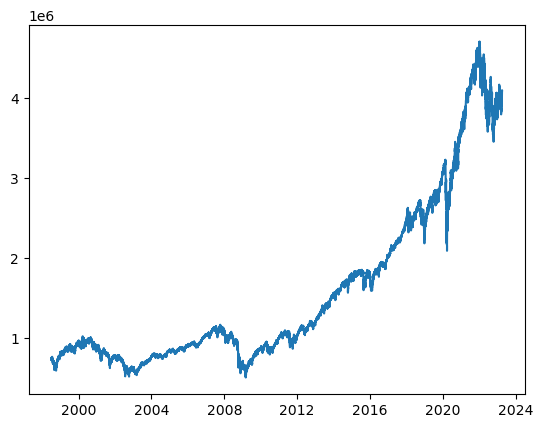

In [8]:
plt.plot(df['Close'])

# Pre-processing

(2399385, 1)


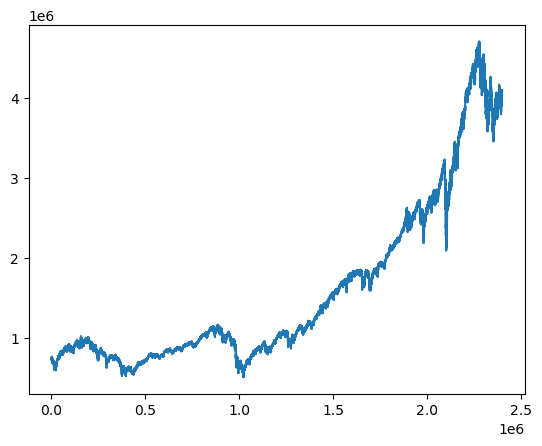

In [9]:
# select features
X = df[['Close']].values 
X = X.astype(np.float32)

# # make data stationary using log returns
# X = np.log(X)
# X = np.diff(X, axis=0)

# # remove 0.01% outliers
# outliers = np.quantile(np.abs(X), 0.9999)
# X = np.clip(X, -outliers, outliers)

# # scale
# X = X / np.max(np.abs(X))

assert(np.isnan(X).any() == False)

plt.plot(X[:, 0])
print(X.shape)

In [10]:
timesteps = 128
features = 1
input_shape = (timesteps, features)
code_size = 32
batch_size = 16
train_index = int(0.7 * len(X))
forecast_horizon = 10

In [11]:
x_train = X[:train_index]
x_test = X[train_index:]

# y_train = x_train[timesteps::timesteps]
# y_test = x_test[timesteps::timesteps]

x_train = window(x_train, timesteps, timesteps)
x_test = window(x_test, timesteps, timesteps)

y_train = np.zeros(len(x_train))
y_test = np.zeros(len(x_test))

for i in range(len(x_train)-1):
    # y_train[i] = np.sum(x_train[i+1, :, 0])
    y_train[i] = np.log(x_train[i+1, forecast_horizon, 0] / x_train[i, -1, 0])
for i in range(len(x_test)-1):
    # y_test[i] = np.sum(x_test[i+1, :, 0])
    y_test[i] = np.log(x_test[i+1, forecast_horizon, 0] / x_test[i, -1, 0])

y_test = np.where(y_test > 0, 1., 0)
y_train = np.where(y_train > 0, 1., 0)

print('Baseline: ', len(np.where(y_test > 0)[0]) / len(y_test))

# scale each window
for i in range(len(x_train)):
    x_train[i] = scale(x_train[i]) * 2. - 1.

for i in range(len(x_test)):
    x_test[i] = scale(x_test[i]) * 2. - 1.

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(x_train.shape[0] == y_train.shape[0])
assert(np.isfinite(y_train).all() == True)
assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_test).all() == True)
assert(np.isfinite(y_train).all() == True)

Baseline:  0.5050684687889028
(13121, 128, 1) (5623, 128, 1)
(13121,) (5623,)


# Data Generation

In [12]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.timesteps = timesteps
        self.data = data
        # self.data = self.window(data, timesteps, strides)
        self.indexes = np.arange(len(self.data) - 1)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    # def window(self, data, timesteps, strides=1):
    #     x = []
    #     for i in range(0, len(data) - timesteps, strides):
    #         x.append(data[i:i+timesteps])
    #     return np.array(x)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.data[idx]
            y_positive = self.data[idx+1]
            
            y_negative = y_positive * -1.

            # v = np.random.choice(np.arange(3))

            # if v == 1:
            #     y_negative = self.data[np.random.choice(indexes)]
            # elif v == 2:
            #     # make y_negative normal distribution from same range as y_positive
            #     y_negative = np.random.lognormal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0]) - 1.
            #     y_negative = np.clip(y_negative, -1.0, 1.0)
            #     y_negative = np.expand_dims(y_negative, -1)

            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [13]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(x, y), labels = dg.__getitem__(0)
print(f"x shape: {x.shape}, y shape: {y.shape}, labels shape: {labels.shape}")

820
x shape: (16, 128, 1), y shape: (16, 128, 1), labels shape: (16, 1)


# Inspecting Windows

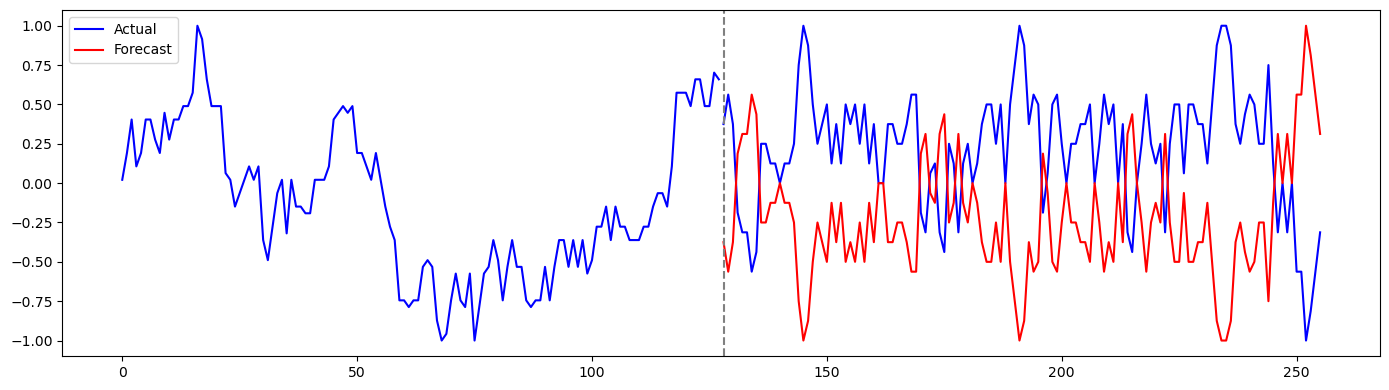

In [14]:
def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(x[0, :, 0], y[0, :, 0], y[1, :, 0])
# plot_forecast(x[2, :, 0], y[2, :, 0], y[3, :, 0])

# Model Architecture

In [15]:
from keras.regularizers import l2

In [16]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(input)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_embedding (Dense)       │ (None, 128, 32)        │         1,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,544 (17.75 KB)

 Trainable params: 4,416 (17.25 KB)

 Non-trainable params: 128 (512.00 B)

In [21]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001), name="context")(input)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    # x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

Model: "context"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ context (LSTM)                  │ (None, 128, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 128, 32)        │         1,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,504 (37.12 KB)

 Trainable params: 9,440 (36.88 KB)

 Non-trainable params: 64 (256.00 B)

In [22]:
# test classification naively 
# x_input = Input(input_shape, name='x_input')
# y_input = Input(input_shape, name='y_input')

# x = keras.layers.Concatenate(axis=1)([x_input, y_input])
# # x = y_input
# x = Conv1D(32, 3, activation='relu', padding='same')(x)
# x = LSTM(32, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=[x_input, y_input], outputs=x, name='CPC')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
# model.summary()

In [23]:
x_input = Input(input_shape)
encoded = encoder(x_input)
y_pred = context(encoded)

y_input = Input(input_shape)
y_encoded = encoder(y_input)

# dot_product = K.sum(y_encoded * y_pred, axis=-1)
# # dot_product = K.mean(y_encoded * y_pred, axis=-1)
# dot_product = K.mean(dot_product, axis=-1, keepdims=True)  # along the temporal dimension

# dot_product = K.sigmoid(dot_product)

# model = Model(inputs=[x_input, y_input], outputs=dot_product, name='CPC')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
# model.summary()

class DotProductLayer(Layer):
    def __init__(self, **kwargs):
        super(DotProductLayer, self).__init__(**kwargs)

    def call(self, inputs):
        y_encoded, y_pred = inputs
        dot_product = tf.reduce_sum(y_encoded * y_pred, axis=-1)
        dot_product = tf.reduce_mean(dot_product, axis=-1, keepdims=True)  # along the temporal dimension
        return tf.sigmoid(dot_product)

# Use the custom layer in your model
dot_product = DotProductLayer()([y_encoded, y_pred])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model = Model(inputs=[x_input, y_input], outputs=dot_product, name='CPC')
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["binary_accuracy"])
model.summary()

Model: "CPC"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 128, 32)   │      4,544 │ input_layer_6[0]… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context             │ (None, 128, 32)   │      9,504 │ encoder[2][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product_layer_1 │ (None, 1)         │          0 │ encoder[3][0],    │
│ (DotProductLayer)   │                   │            │ context[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,048 (54.88 KB)

 Trainable params: 13,856 (54.12 KB)

 Non-trainable params: 192 (768.00 B)

In [24]:
batch_size = 256
epochs = 300

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=False)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=False)

In [25]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/300


/Users/antonykrymski/miniconda3/envs/base2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - binary_accuracy: 0.5011 - loss: 0.8294 - val_binary_accuracy: 0.4929 - val_loss: 0.7434
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - binary_accuracy: 0.5185 - loss: 0.7732 - val_binary_accuracy: 0.5020 - val_loss: 0.7433
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - binary_accuracy: 0.5111 - loss: 0.7723 - val_binary_accuracy: 0.5015 - val_loss: 0.7482
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - binary_accuracy: 0.4975 - loss: 0.7717 - val_binary_accuracy: 0.5002 - val_loss: 0.7618
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - binary_accuracy: 0.5083 - loss: 0.7651 - val_binary_accuracy: 0.5032 - val_loss: 0.7588
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - binary_accuracy: 0.5111 - loss: 0.7627 - val_binary_accuracy: 0.5255 - val_loss: 0.7414
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - binary_accuracy: 0.5215 - loss: 0.7553 - val_binary_accuracy: 0.5465 - val_loss: 0.7330
Epoch 8/300
51/51

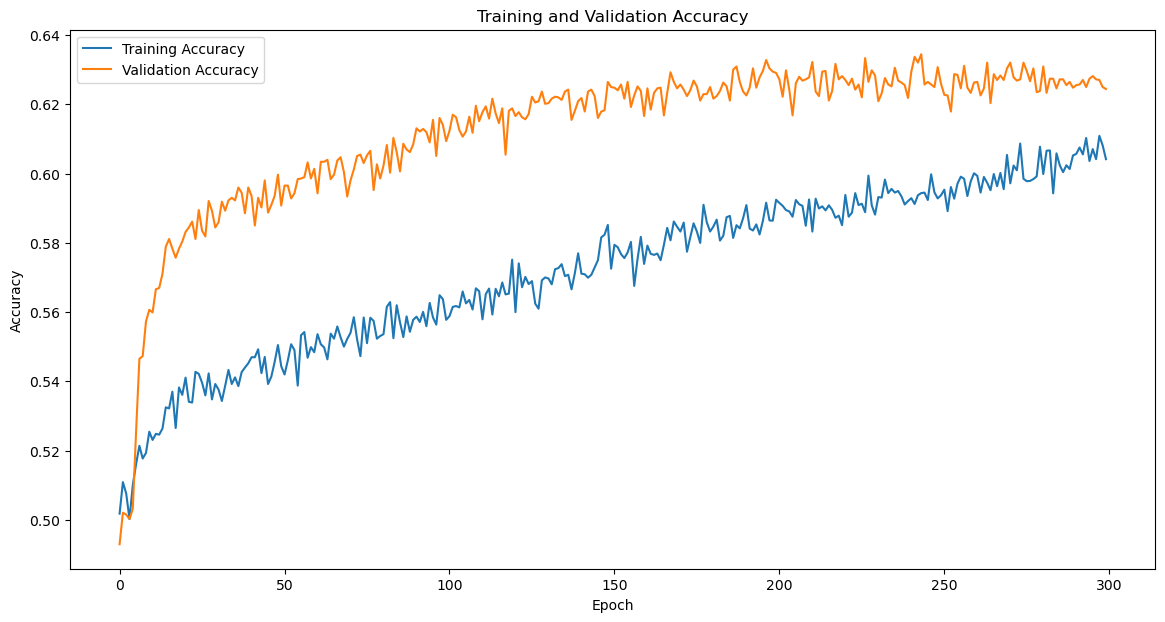

In [26]:
plot_training(history)

In [277]:
encoder.save('encoder.h5', include_optimizer=False)

In [70]:
# # compute embeddings in a rolling fashion for the entire time series 
# # WARNING: takes a while
# encoder = load_model('encoder.h5', compile=True)

# Xh = np.zeros((len(X) - timesteps, code_size))
# Yh = np.zeros((len(X) - timesteps))

# batch_size = 100000
# indexes = np.arange(len(X) - timesteps)
# batches = len(indexes) // batch_size

# for batch in range(batches):
#     print(int(batch / batches * 100))
#     idx = indexes[batch*batch_size:(batch+1)*batch_size]
#     embeddings = encoder.predict(np.array([ X[i:i+timesteps] for i in idx ]))

#     for i in idx:
#         Xh[i] = embeddings[i - idx[0], 0, :]
#         Yh[i] = np.sum(X[i:i+timesteps])

# np.save('embeddings.h5', Xh)

# print(Xh.shape, Yh.shape)

# Downstream Task

In [278]:
def build_forecasting(input_shape, encoder_file):
    encoder = load_model(encoder_file, compile=True)
    encoder.trainable = False  # Freeze the encoder model
    input = Input(input_shape)
    x = encoder(input)
    x = GRU(128, return_sequences=True)(x)
    x = GRU(128)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

fm = build_forecasting(input_shape, 'encoder.h5')
fm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
fm.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 encoder (Functional)        (None, 128, 32)           103200    
                                                                 
 gru_24 (GRU)                (None, 128, 128)          62208     
                                                                 
 gru_25 (GRU)                (None, 128)               99072     
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 281,121
Trainable params: 177,921
Non-traina

In [285]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_ds.h5',
    monitor='val_binary_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

history = fm.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
206/206 [==============================] - 12s 56ms/step - loss: 0.6915 - binary_accuracy: 0.5274 - val_loss: 0.6945 - val_binary_accuracy: 0.4937
Epoch 2/10
206/206 [==============================] - 11s 54ms/step - loss: 0.6914 - binary_accuracy: 0.5244 - val_loss: 0.6995 - val_binary_accuracy: 0.4958
Epoch 3/10
206/206 [==============================] - 12s 57ms/step - loss: 0.6917 - binary_accuracy: 0.5252 - val_loss: 0.6950 - val_binary_accuracy: 0.4901
Epoch 4/10
206/206 [==============================] - 11s 52ms/step - loss: 0.6914 - binary_accuracy: 0.5247 - val_loss: 0.6952 - val_binary_accuracy: 0.4919
Epoch 5/10
206/206 [==============================] - 10s 51ms/step - loss: 0.6916 - binary_accuracy: 0.5193 - val_loss: 0.6965 - val_binary_accuracy: 0.4908
Epoch 6/10
206/206 [==============================] - 11s 53ms/step - loss: 0.6915 - binary_accuracy: 0.5263 - val_loss: 0.6961 - val_binary_accuracy: 0.4907
Epoch 7/10
206/206 [==============================] 

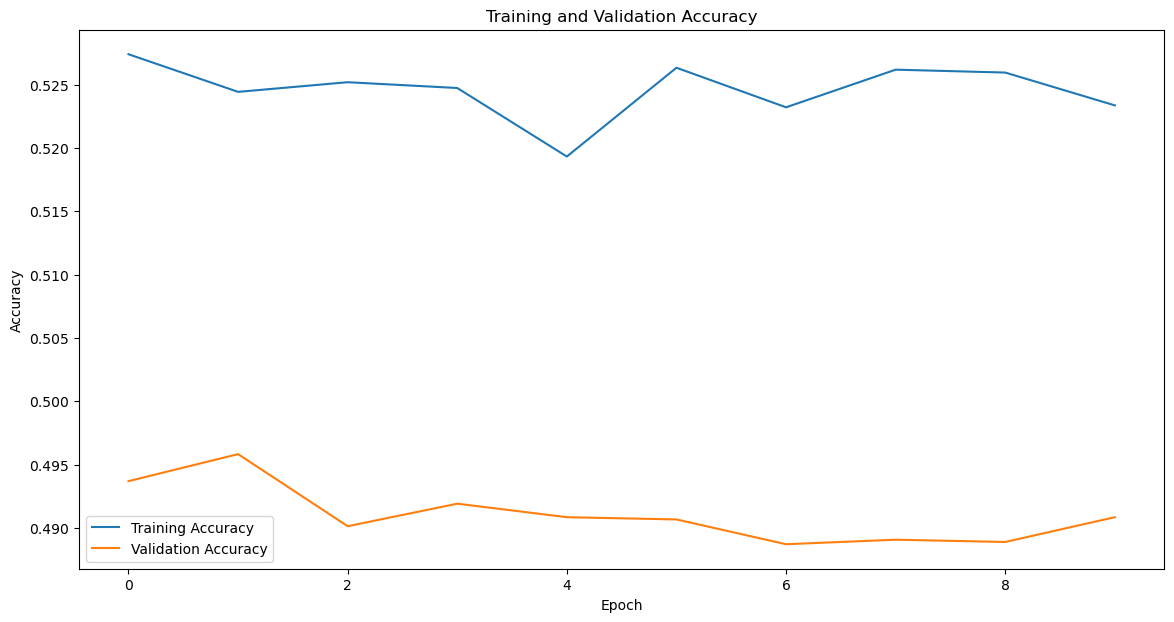

In [286]:
plot_training(history)

In [287]:
from sklearn.metrics import classification_report

y_pred = fm.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))

176/176 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

         0.0       0.49      0.80      0.61      2783
         1.0       0.49      0.19      0.27      2840

    accuracy                           0.49      5623
   macro avg       0.49      0.49      0.44      5623
weighted avg       0.49      0.49      0.44      5623

